# Panama Papers: Discovery of Corruption

* Students: Ilija Gjorgjiev, Gauthier Mueller, Mahmoud Zgolli
* Dataset: Panama Papers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from py2neo import Graph, Node, Relationship
import neo4jupyter
import networkx as nx
import csv, os, sys
import math

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

from pputils import *

neo4jupyter.init_notebook_mode()

%matplotlib inline


<IPython.core.display.Javascript object>

# 1. Load and convert Data

The downloaded dataset file has 5 csv files.

1. Entity: Offshore company created in a low-tax by an offshore jurisdiction agent.

2. Officer: Person or company who plays a role in an offshore entity.

3. Edges : 

4. Address: A contact postal address.

5. Intermediary: Intermediar between someone looking for an offshore corporation and an offshore service provider.

In [2]:
#Load Panama Data
panama_entity = pd.read_csv('./Data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
panama_officer = pd.read_csv('./Data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
panama_edges = pd.read_csv("./Data/panama_papers/panama_papers.edges.csv", low_memory=False)
panama_address = pd.read_csv("./Data/panama_papers/panama_papers.nodes.address.csv", low_memory=False)
panama_intermediary = pd.read_csv("./Data/panama_papers/panama_papers.nodes.intermediary.csv", low_memory=False)
panama_power_players_nodes = pd.read_csv("./Data/power_players_panama_nodes.csv")
panama_power_players_nodes = panama_power_players_nodes.drop(columns=["Unnamed: 0"])

In [280]:
#Load Paradise Data 
paradise_entity = pd.read_csv("./Data/paradise_papers/paradise_papers.nodes.entity.csv", low_memory = False)
paradise_edges = pd.read_csv("./Data/paradise_papers/paradise_papers.edges.csv", low_memory = False)
paradise_address = pd.read_csv("./Data/paradise_papers/paradise_papers.nodes.address.csv", low_memory = False)
paradise_officer = pd.read_csv("./Data/paradise_papers/paradise_papers.nodes.officer.csv", low_memory = False)
paradise_intermediary = pd.read_csv("./Data/paradise_papers/paradise_papers.nodes.intermediary.csv", low_memory = False)
paradise_other = pd.read_csv("./Data/paradise_papers/paradise_papers.nodes.other.csv", low_memory = False)
paradise_power_players_nodes = pd.read_csv("./Data/paradise_power_players.csv")
paradise_power_players_nodes = paradise_power_players_nodes.drop(columns=["Unnamed: 0"])

# 2. Explore data

## 2.1 Panama entity
We First explore the entity dataset to undersand it a little bit 

In [374]:
#Convert Date/Time Values
panama_entity['incorporation_date'] = pd.to_datetime(panama_entity['incorporation_date'])
panama_entity['inactivation_date'] = pd.to_datetime(panama_entity['inactivation_date'])
#panama_entity['struck_off_date'] = pd.to_datetime(panama_entity['struck_off_date'])
panama_entity["closed_date"] = pd.to_datetime(panama_entity["closed_date"])

In [375]:
print(panama_entity.shape)
panama_entity.head(2)

(213634, 17)


,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",SAM,Samoa,HKG,Hong Kong,2006-03-23,2013-02-18,15-FEB-2013,NaT,25221,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",SAM,Samoa,HKG,Hong Kong,2006-03-27,2014-02-27,15-FEB-2014,NaT,25249,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN


## 2.2 Dataset

### 2.2.1 General information 

We start by getting the genral informations abot or dataset such as :

- The nationality of the Top 10 present offshore companies: We can see that Switzerlnd and Hongkong are by far the most present firm nationalities. All the present countries are developped ones.

- The nationality of the Top 15 present offshore juridiction firms: This a log plot, The british virging islands are the most preset juridiction firms.

- The evoluution of number of entities along the years: It all started around 1975 and the nmber increased exponantially. With 2 major crises in 2003 and 2010. 

- The  Top 10 present relation types:This is also a log plot, The shareholders are the most preset relations .

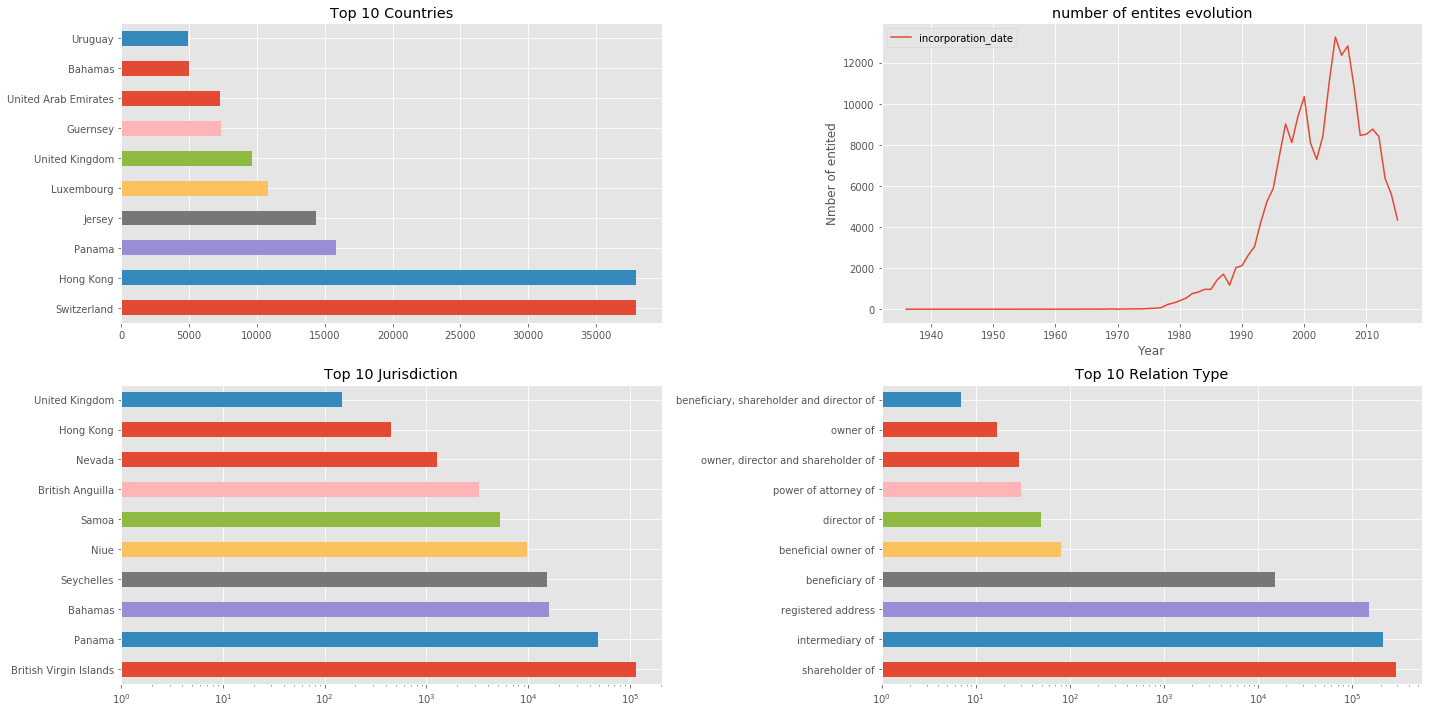

In [376]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
panama_entity["countries"].value_counts().head(10).plot.barh(title="Top 10 Countries", ax=axes[0,0])
ax=pd.DataFrame(panama_entity['incorporation_date'].dropna().dt.year.astype(int).value_counts()).sort_index().plot.line(title='number of entites evolution',ax= axes[0,1])
panama_entity["jurisdiction_description"].value_counts().head(10).plot.barh(log = True, title="Top 10 Jurisdiction", ax = axes[1,0])
panama_edges["link"].value_counts().head(10).plot.barh(log=True, title = "Top 10 Relation Type", ax = axes[1,1])
ax.set_xlabel('Year')
ax.set_ylabel('Nmber of entited')
plt.tight_layout()
plt.show()

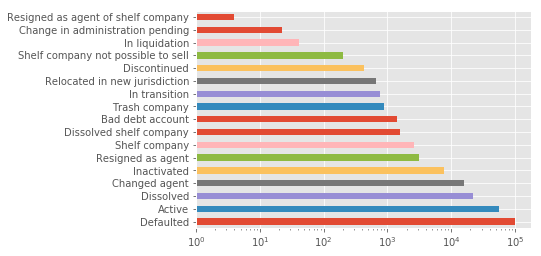

In [378]:
#Top 10 Statuses of Entities
panama_entity["status"].value_counts().plot.barh(log=True)

# 3. Correlation between countries and some indexes
Our reserach question was to find a common point between between the most citied countries. For this reason, in this section we will be calculationg the correlation between the frequencty of eachy co!untry presence in the papers and some general indexes.

In [5]:
#Import corruption index data
corruption_index = pd.read_csv("./Data/corruption_index.csv", low_memory=False, encoding='latin-1')
#Import peace index dataset
peace_index = pd.read_csv("./Data/gpi_2008-2016.csv", low_memory=False)
#Import HDi index dataset
dev = pd.read_csv("./Data/2018_Statistical_Annex_Table_1.csv", encoding='latin-1',header=6)

## 3.1 Generarl function to plot data from WORLD BANK
The world bank is a is aplateforme where one can find all kind if indices https://data.worldbank.org/ . This function is used to plot the indexes found in this plateforme. 

In [380]:
def data_read(data_name,frequency,log_on,freq_limit,idx_limit,how,title):
    
    apiBase = "http://api.worldbank.org/indicator/"
    apiIndicator = data_name    # This can be changed to any other indicator
    source = apiBase+apiIndicator+"?format=csv"
    
    #Import gini index data
    raw_data = pd.read_csv(source)
    
    #Datawrangling
    lst =[str(x) for x in range(1960,2018)]
    mean_data=pd.DataFrame()
    mean_data['Country']=raw_data['Country Name']
    if how=='mean':
        mean_data['IDX']=raw_data[lst].mean(axis=1) # take the mean over the years 
    else:
        mean_data['IDX']=raw_data[how]
    mean_data['IDX']=pd.to_numeric(mean_data['IDX'])    # take the mean over the years 
    
    #merge gini with frequency 
    freq_data = pd.merge(frequency,mean_data,how='inner').dropna()
    #only countries existing more than 100 times
    freq_data =freq_data[freq_data['frequency'].apply(lambda x: x>freq_limit[0]  ) & freq_data['frequency'].apply(lambda x: x<freq_limit[1] )]
    freq_data =freq_data[freq_data['IDX'].apply(lambda x: x>idx_limit[0]) &  freq_data['IDX'].apply(lambda x: x<idx_limit[1])]
    
    #plot the gini index vs frquency 
    slope, intercept, r_value, p_value, std_err = stats.linregress(freq_data['IDX'], freq_data['frequency'])

    sns.set(rc={'figure.figsize':(15,8)})
    ax = sns.regplot(x="frequency", y="IDX", data=freq_data, color="g", n_boot=500, y_jitter=.03).set_title(title)
    
    #correlation and p values 
    print("Correlation Value", r_value) 
    print("P Value", p_value)
    

## 3.2 Frequency of the countries.
First of all we start by calculationg the frequency of each country presence in the officers, intermediary, entity and address datasets. These frequency will be used later. 

In [381]:
#Calculte the frequency of the country in the:
#officers dataset
officer_frequency=pd.DataFrame(panama_officer["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#intermediary dataset
intermediar_frequency=pd.DataFrame(panama_intermediary["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#Enctity dataset
entity_frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#Address dataset
address_frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

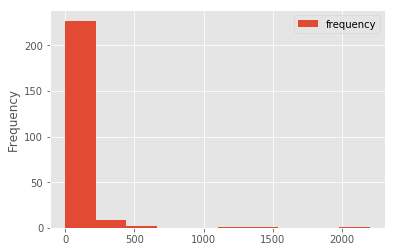

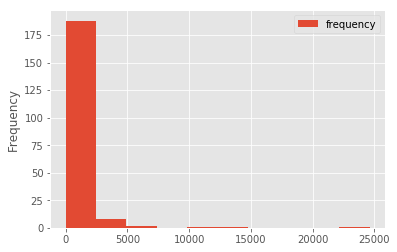

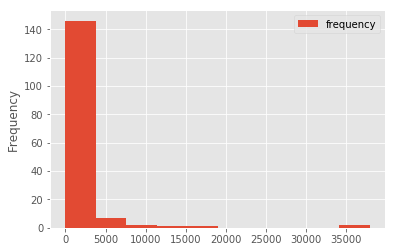

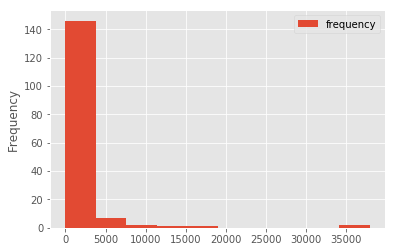

In [382]:
intermediar_frequency.plot(kind='hist')
officer_frequency.plot(kind='hist')
address_frequency.plot(kind='hist')
entity_frequency.plot(kind='hist')

## 3.3 Gini index

The Gini index  is a statistical measure of distribution used as a gauge of economic inequality, measuring income distribution or, less commonly, wealth distribution among a population. The coefficient ranges from  0% to  100%. 
The Gini index and the entities origin country frequency has a correlation equal to 0.37058975049658943 with a p-value 0.018572682928927605. If this probability is lower than the conventional 5% ( 95% confidence interval for the correlation coefficient) the correlation coefficient is called statistically significant.
 In other words the correlation  between the Gini index and entities country frequency  is indeed correct and significant. However, It is a low correlation, because there were a lot of outliers that we removed and it confers only countries  cited more between 5 and 8000 times with Gini index less than 40, in other words poor countries.  


Correlation Value 0.26007629252815967
P Value 0.09623567548444552


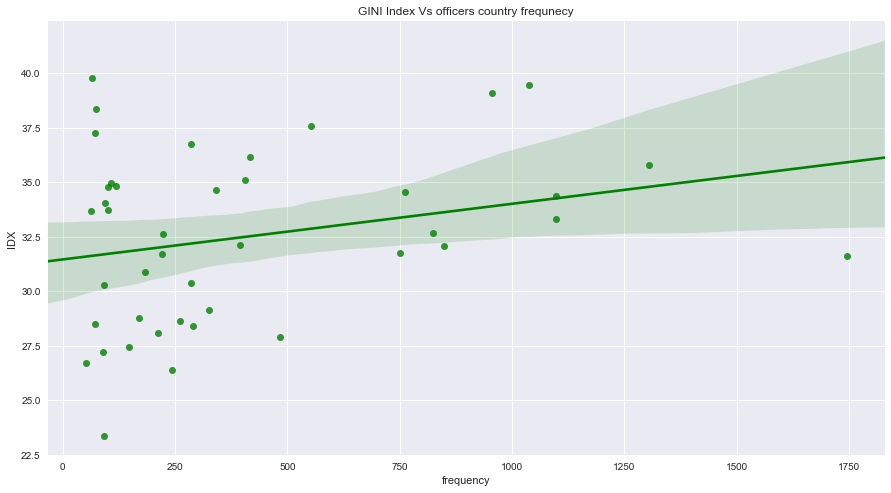

In [383]:
#Corremation between the Gini index and  the officer origin countries frequency
#Name of the data in th worls economic database
data_name="SI.POV.GINI"

# If we want to plot a log corremation or not. 
log_on=False

# The limit ofe frequency
freq_limit=[50,2000]

#index limit 
idx_limit=[0,40]

# Which year of the index where mean means the mean along the years
how='mean'

# The title of the plot 
title= 'GINI Index Vs officers country frequnecy'

# Caling the function to plot 
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how,title)

#The number below are the correlation a dnthe value 

Correlation Value 0.37058975049658943
P Value 0.018572682928927605


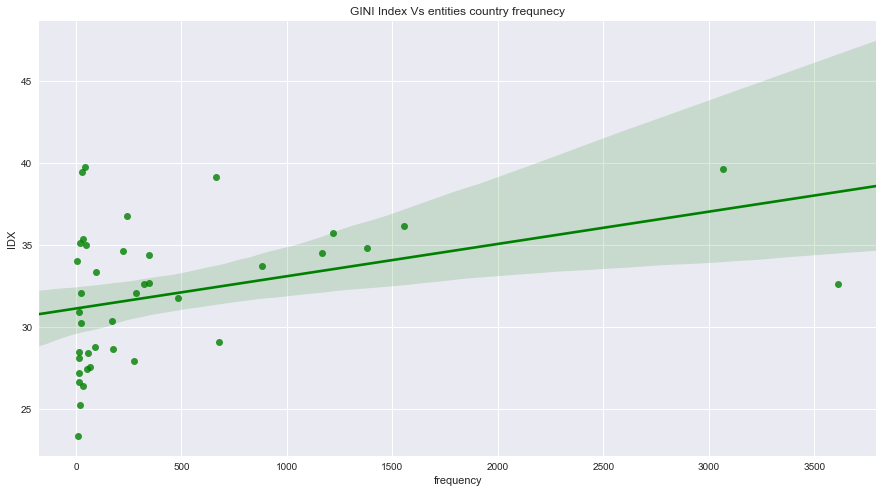

In [385]:
data_name="SI.POV.GINI"
log_on=False
freq_limit=[5,8000]
idx_limit=[0,40]
how='mean'
title= 'GINI Index Vs entities country frequnecy'
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how,title)

## 3.4 Corruption index 

The second index is the perceived corruption index. In this case there is also a very low correlation between the officers country frequency and the corruption index  of 0.2903529327551021 with p-value 0.000247455687383302. This correlation is statically significant. However the majority of the countries are cited less than 200 times. This result makes sense, the more the country is corrupted, the more it is cited. Corrupted countries have corrupted corrupted officers. The perceived corruption index is also correlated with the Panama address with   0.31385266422046715 and p value 8.235035924362218e-05 . The correlation is lower with the the intermediary with 0.22905312295895672 and p value 0.02637461882225528. 

0.2869078070759335
0.00030907631628341415


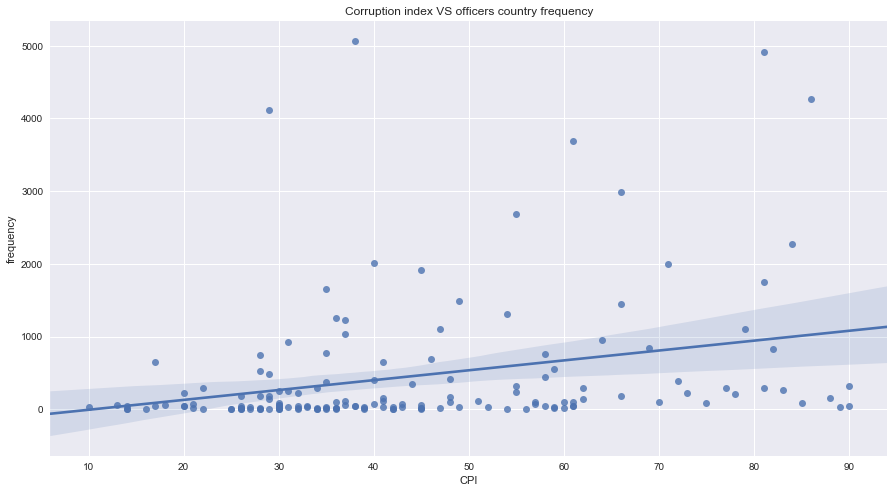

In [387]:
frequency=pd.DataFrame(panama_officer["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#Corruption Data change indices names  
corr_index=corruption_index[['Country','CPI']]

#merge with frequency 
freq_corruption = pd.merge(frequency,corr_index,how='inner')

#only countries existing more than 100 times
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x<12000)]
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x>0)]

#plot the corruption index vs frquency 
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_corruption.CPI, freq_corruption.frequency)
ax = sns.regplot(x="CPI", y="frequency", data=freq_corruption, n_boot=500, y_jitter=.03).set_title('Corruption index VS officers country frequency')
#correlation and p values 

print(r_value)
print(p_value)

0.22905312295895658
0.026374618822255367


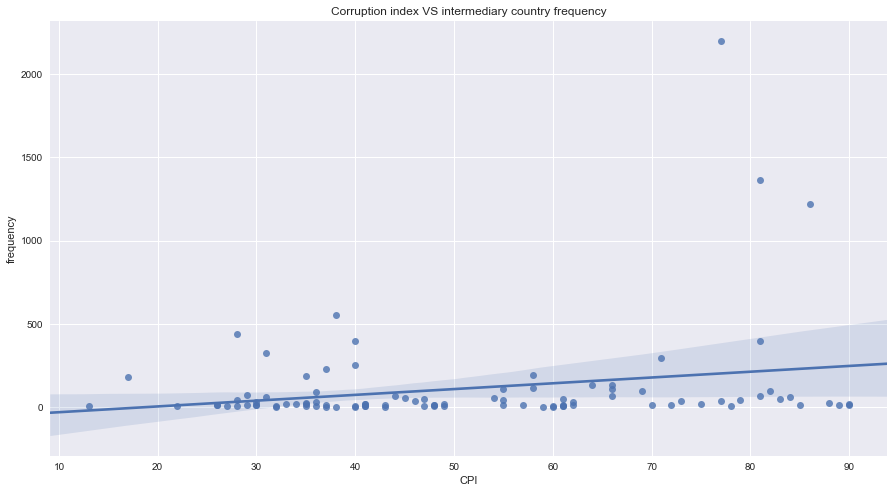

In [389]:
frequency=pd.DataFrame(panama_intermediary["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})
#Import corruption index data
corruption_index = pd.read_csv("./Data/corruption_index.csv", low_memory=False, encoding='latin-1')

#Corruption Data change indices names  
corr_index=corruption_index[['Country','CPI']]

#merge with frequency 
freq_corruption = pd.merge(frequency,corr_index,how='inner')

#only countries existing more than 100 times
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x<10000)]
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x>1)]

#plot the corruption index vs frquency 
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_corruption.CPI, freq_corruption.frequency)
ax = sns.regplot(x="CPI", y="frequency", data=freq_corruption, n_boot=500, y_jitter=.03).set_title('Corruption index VS intermediary country frequency')

#correlation and p values 
print(r_value)
print(p_value)

0.19152385622772675
0.04503064520656991


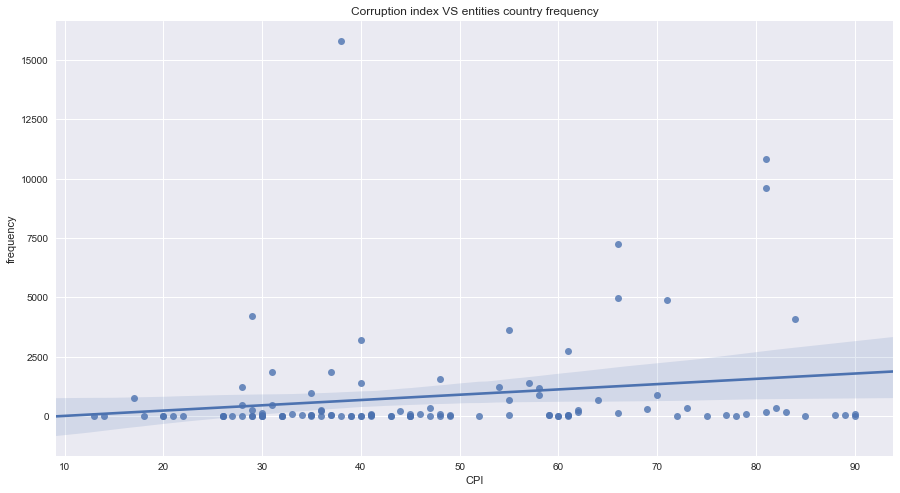

In [391]:
frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#Corruption Data change indices names  
corr_index=corruption_index[['Country','CPI']]

#merge with frequency 
freq_corruption = pd.merge(frequency,corr_index,how='inner')

#only countries existing more than 100 times
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x<30000)]
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x>1)]

#plot the corruption index vs frquency 
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_corruption.CPI, freq_corruption.frequency)
ax = sns.regplot(x="CPI", y="frequency", data=freq_corruption, n_boot=500, y_jitter=.03).set_title('Corruption index VS entities country frequency')

#correlation and p values 
print(r_value)
print(p_value)

0.31385266422046704
8.235035924362242e-05


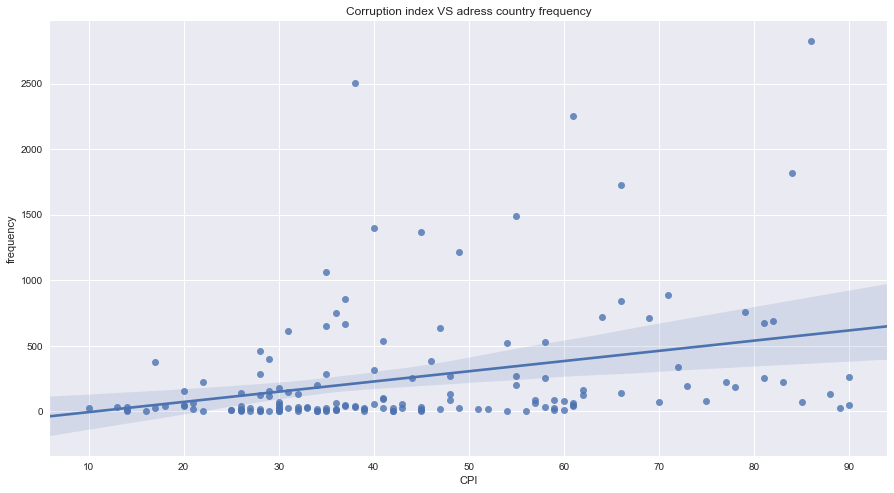

In [392]:
frequency=pd.DataFrame(panama_address["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#Corruption Data change indices names  
corr_index=corruption_index[['Country','CPI']]

#merge with frequency 
freq_corruption = pd.merge(frequency,corr_index,how='inner')

#only countries existing more than 100 times
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x<3000)]
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x>0)]

#plot the corruption index vs frquency 
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_corruption.CPI, freq_corruption.frequency)
ax = sns.regplot(x="CPI", y="frequency", data=freq_corruption, n_boot=500, y_jitter=.03).set_title('Corruption index VS adress country frequency')

#correlation and p values 
print(r_value)
print(p_value)

## 3.5 Peace index
The peace index seemed interesstion to us, We tested this index and we found a negative correlation of -0.42. However the p value is big (higher than 0.05), this corremation is as a resulkt not meaningful.

-0.41948776399466253
0.09369760362782474


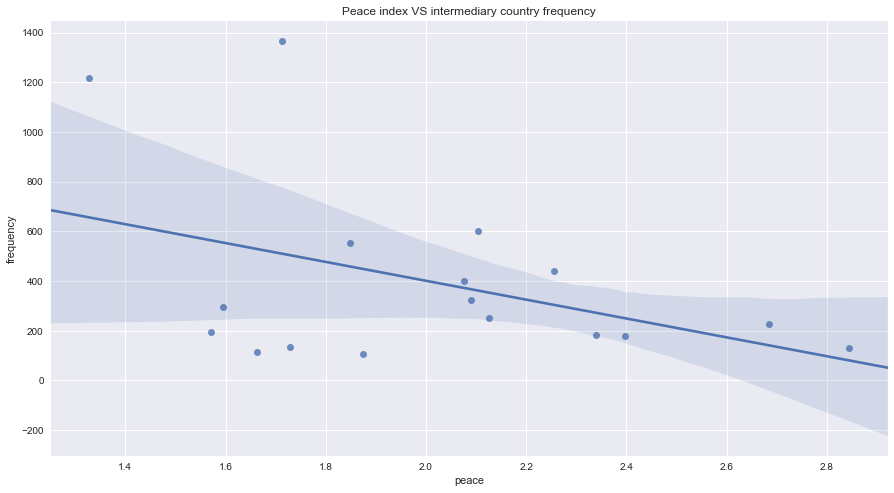

In [395]:
frequency=pd.DataFrame(panama_intermediary["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#select the country and the mean of peace index from 2008 to 2016
peace_index=peace_index[['Country','peace']]
#merge peace with frequency 
freq_peace = pd.merge(frequency,peace_index,how='inner')
#only countries existing more than 100 times
freq_peace =freq_peace[freq_peace['frequency'].apply(lambda x: x>100)]
freq_peace =freq_peace[freq_peace['frequency'].apply(lambda x: x<30000)]
#plot the peace index vs frquency 
#freq_peace[['peace','frequency']].plot(kind='scatter', x='peace', y='frequency', grid=True,figsize=(14,5))
ax = sns.regplot(x="peace", y="frequency", data=freq_peace, n_boot=500, y_jitter=.03).set_title('Peace index VS intermediary country frequency')
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_peace.peace, freq_peace.frequency)
#plt.plot(freq_peace.peace, intercept + slope*freq_peace.peace, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

## 3.6 Foreign direct investment as  % of GDP
We also tried this index and we found nothingnintessting. It was corrematrd with non of the datasets. We tried this because we suspected that the offshore companies are supposed as foreng investment.

## 3.7 Service exports (BoP, current US dolar)
The third index is the service ecxports (BoP,US dollars). With this we want to show that service  countries have more entities and officers cited. In fact service countries have more money laundry and have more money transactions with the offshore countries. In fact there is a low correlation between the service exports and the officers with  0.3544542144618415 an p value 1.2191864422245798e-05 .

Correlation Value 0.3544542144618418
P Value 1.2191864422245637e-05


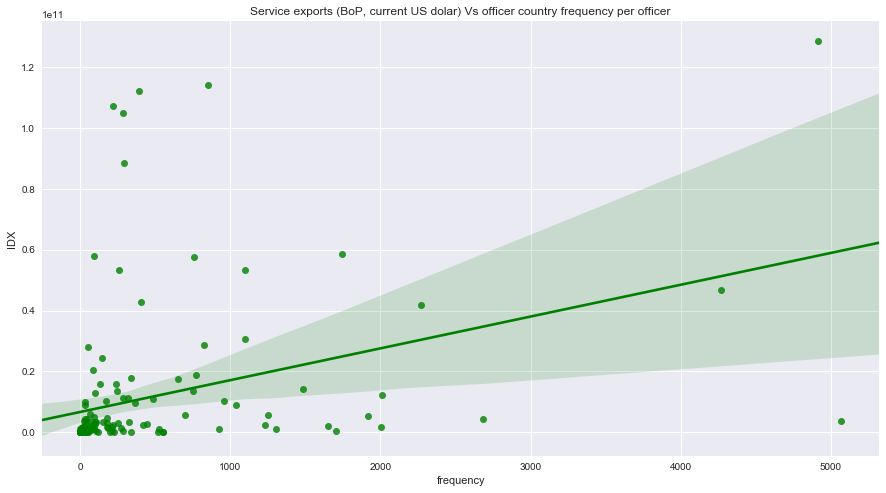

In [407]:
data_name="BX.GSR.NFSV.CD" 
log_on=True
freq_limit=[0,15000]
idx_limit=[0,1.5e11]
how='mean'
title='Service exports (BoP, current US dolar) Vs officer country frequency per officer'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how,title)

## 3.8 Insurance and financial services (% of service exports, BoP)
 Since in the service exports we are more interested in the financial services we checked with the fourth index is the insurance and financial servies as % of service exports. As expected the correlation is higher  in this case with the officer countries with  0.4102701171441421 and p vzalue 3.9620220677934937e-07. 


Correlation Value 0.4102701171441419
P Value 3.9620220677935377e-07


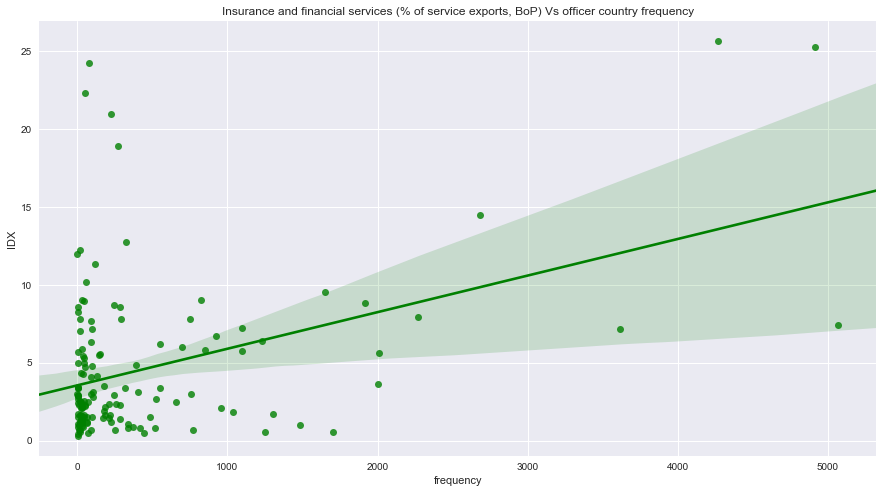

In [402]:
data_name="BX.GSR.INSF.ZS"
log_on=True
freq_limit=[0,20000]
idx_limit=[0,40]
how='mean'
title='Insurance and financial services (% of service exports, BoP) Vs officer country frequency'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how,title)

Correlation Value 0.47539233531604647
P Value 4.439840473591408e-07


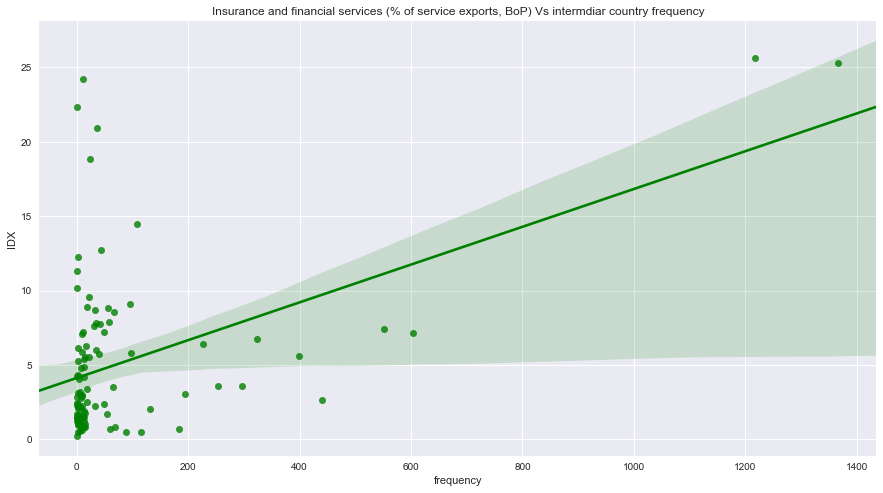

In [403]:
data_name="BX.GSR.INSF.ZS"
log_on=False
freq_limit=[0,10000]
idx_limit=[0,40]
how='mean'
title='Insurance and financial services (% of service exports, BoP) Vs intermdiar country frequency'
data_read(data_name,intermediar_frequency,log_on,freq_limit,idx_limit,how,title)

Correlation Value 0.26862187360414863
P Value 0.0053658968151690896


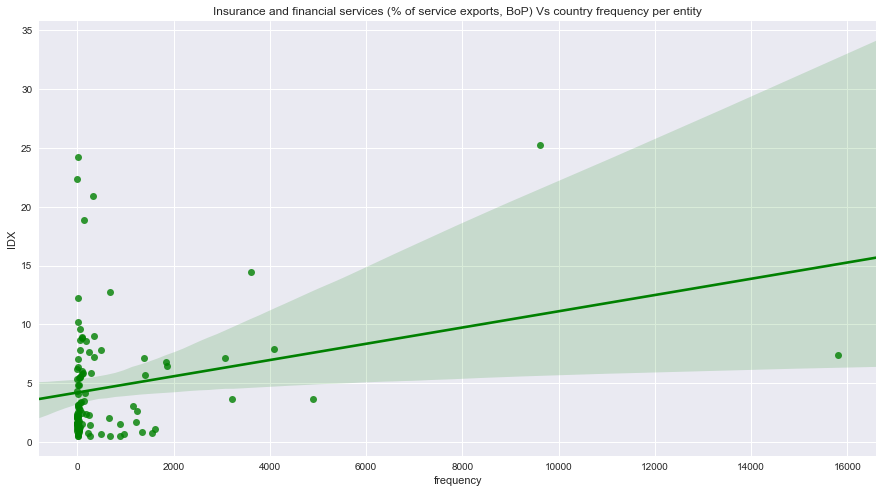

In [404]:
data_name="BX.GSR.INSF.ZS"
log_on=False
freq_limit=[1,16000]
idx_limit=[0,40]
how='mean'
title='Insurance and financial services (% of service exports, BoP) Vs country frequency per entity'
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how, title)

## 3.9 Corruption VS Services 
From the previous graph we saw that the origin countries are correlated with the corruption and the service exports. For this reason we plot the perceived corrution as a function of the service exports for each country and we find a correlation of 0.5458846576026938 with p value 7.216328423040093e-13. This may indicates that the service country are maybe more corrupted ones. 


0.5458846576026933
7.216328423040432e-13
5.395836400819054e-11


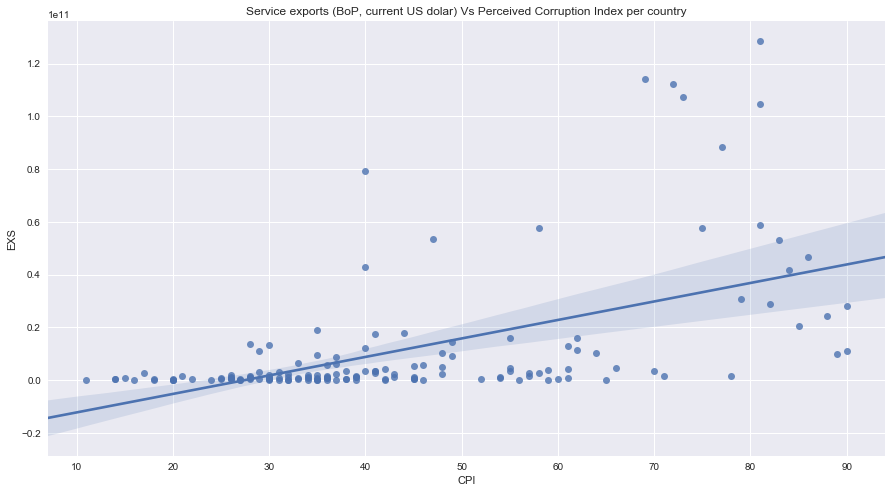

In [411]:
# Building query to fetch data from API
apiBase = "http://api.worldbank.org/indicator/"
apiIndicator4 = "BX.GSR.NFSV.CD"    # This can be changed to any other indicator
source4 = apiBase+apiIndicator4+"?format=csv"
#Import gini index data
exp_s = pd.read_csv(source4)
#Datawrangling
lst =[str(x) for x in range(1960,2018)]
exp_service=pd.DataFrame()
exp_service['Country']=exp_s['Country Name']
exp_service['EXS']=exp_s[lst].mean(axis=1) # take the mean over the years 
exp_service['EXS']=pd.to_numeric(exp_service['EXS'])    # take the mean over the years 

        
corrup_service = pd.merge(corr_index,exp_service,how='inner').dropna()
#plot the gini index vs frquency 
corrup_service =corrup_service[corrup_service['CPI'].apply(lambda x: x>1)]
corrup_service =corrup_service[corrup_service['EXS'].apply(lambda x: x< 20e11)]
#corrup_service[['CPI','EXS']].plot(kind='scatter', x='EXS', y='CPI',loglog=True, grid=True,figsize=(14,5))
#corrup_service[['CPI','EXS']].plot(kind='hist',bins=20, x='EXS', y='CPI',loglog=True, grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(corrup_service['EXS'], corrup_service['CPI'])
title = "Service exports (BoP, current US dolar) Vs Perceived Corruption Index per country"
ax = sns.regplot(x="CPI", y="EXS", data=corrup_service, n_boot=500, y_jitter=.03).set_title(title)
#plt.plot(corrup_service['EXS'], intercept + slope*corrup_service['EXS'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)
print(std_err)

## 3.10 Humand D I vs frequency 
The fifth index is the human development index  and there is a  logarithmic correlation with the Panama entries, officers and intermediaries of  around  0.4207873006904997 and value 2.8349214305321715e-06 . This means that the countries are are more developed are cited more. This result was not like expected, We was expecting that the less developed countries are more cited but it was not. 

/Users/ilijagjorgjiev/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


0.1855124525056011
0.05692551400547635


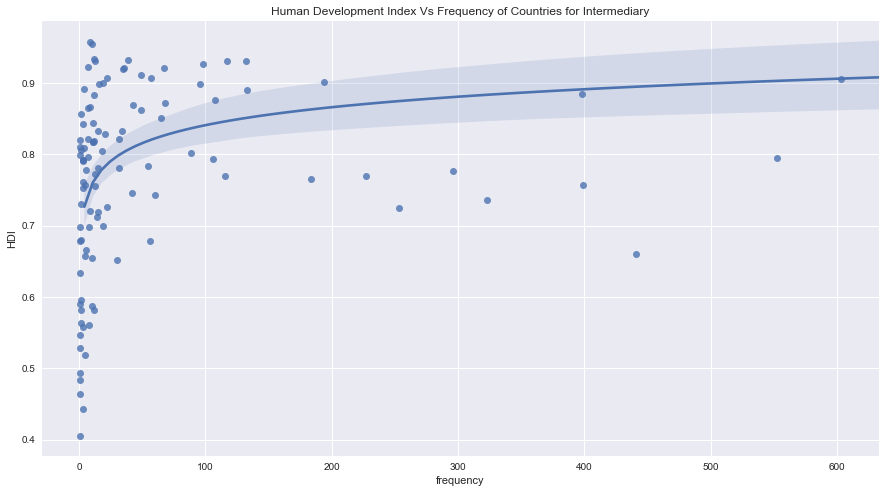

In [412]:
frequency=pd.DataFrame(panama_intermediary["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#select the country and the HDI index
dev_index=pd.DataFrame()
dev_index['HDI']=pd.to_numeric(dev['HDI'])
dev_index['Country']=dev['Country']
#merge HDI with frequency 
freq_hdi = pd.merge(frequency,dev_index,how='inner')
#only countries existing more than 100 times
freq_hdi =freq_hdi[freq_hdi['frequency'].apply(lambda x: x<1000)]

freq_hdi=freq_hdi.dropna()
#plot the HDI index vs frquency 
#freq_hdi[['HDI','frequency']].plot(kind='scatter',logy=True, x='HDI', y='frequency', grid=True,figsize=(14,5))
title = "Human Development Index Vs Frequency of Countries for Intermediary"
ax = sns.regplot(x="frequency", y="HDI", data=freq_hdi, n_boot=500, y_jitter=.03,logx=True).set_title(title)
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_hdi.HDI, freq_hdi.frequency)
#plt.plot(freq_hdi.HDI, intercept + slope*freq_hdi.HDI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

/Users/ilijagjorgjiev/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


0.4207873006905
2.83492143053212e-06


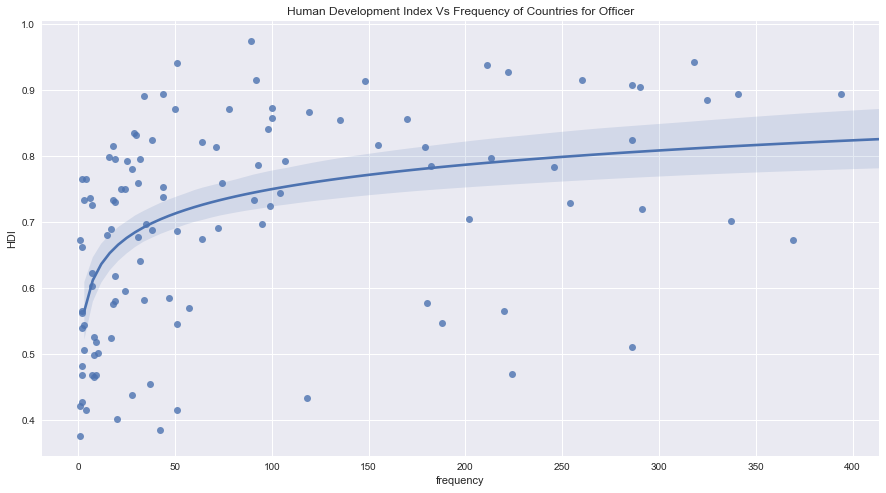

In [413]:
frequency=pd.DataFrame(panama_officer["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#select the country and the HDI index
dev_index=pd.DataFrame()
dev_index['HDI']=pd.to_numeric(dev['HDI'])
dev_index['Country']=dev['Country']
#merge HDI with frequency 
freq_hdi = pd.merge(frequency,dev_index,how='inner')
#only countries existing more than 100 times
freq_hdi =freq_hdi[freq_hdi['frequency'].apply(lambda x: x<400)]

freq_hdi=freq_hdi.dropna()
#plot the HDI index vs frquency 
#freq_hdi[['HDI','frequency']].plot(kind='scatter',logy=True, x='HDI', y='frequency', grid=True,figsize=(14,5))
title = "Human Development Index Vs Frequency of Countries for Officer"
ax = sns.regplot(x="frequency", y="HDI", data=freq_hdi, n_boot=500, y_jitter=.03,logx=True).set_title(title)
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_hdi.HDI, freq_hdi.frequency)
#plt.plot(freq_hdi.HDI, intercept + slope*freq_hdi.HDI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

/Users/ilijagjorgjiev/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


0.43424425295886365
1.3685198184065328e-05


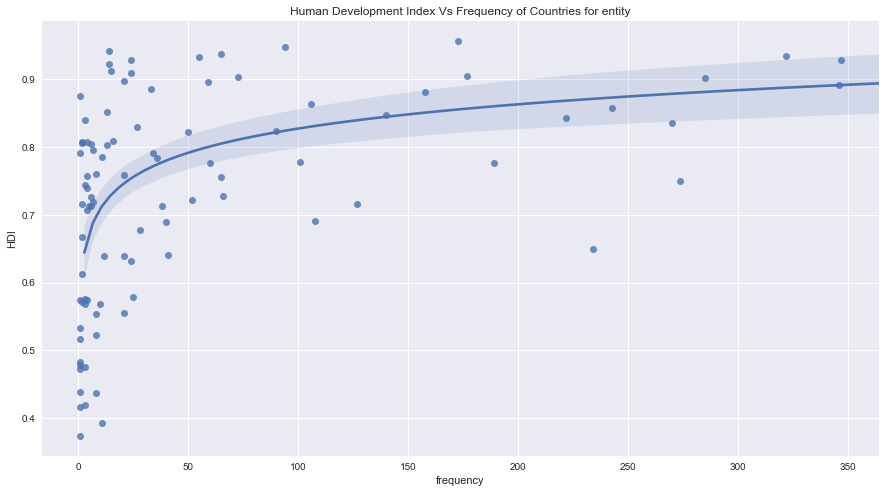

In [414]:
frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#select the country and the HDI index
dev_index=pd.DataFrame()
dev_index['HDI']=pd.to_numeric(dev['HDI'])
dev_index['Country']=dev['Country']
#merge HDI with frequency 
freq_hdi = pd.merge(frequency,dev_index,how='inner')
#only countries existing more than 100 times
freq_hdi =freq_hdi[freq_hdi['frequency'].apply(lambda x: x<400)]

freq_hdi=freq_hdi.dropna()
#plot the HDI index vs frquency 
#freq_hdi[['HDI','frequency']].plot(kind='scatter',logy=True, x='HDI', y='frequency', grid=True,figsize=(14,5))
title = "Human Development Index Vs Frequency of Countries for entity"
ax = sns.regplot(x="frequency", y="HDI", data=freq_hdi, n_boot=500, y_jitter=.03,logx=True).set_title(title)
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_hdi.HDI, freq_hdi.frequency)
#plt.plot(freq_hdi.HDI, intercept + slope*freq_hdi.HDI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

/Users/ilijagjorgjiev/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


0.40242515423191877
3.282536396193049e-06


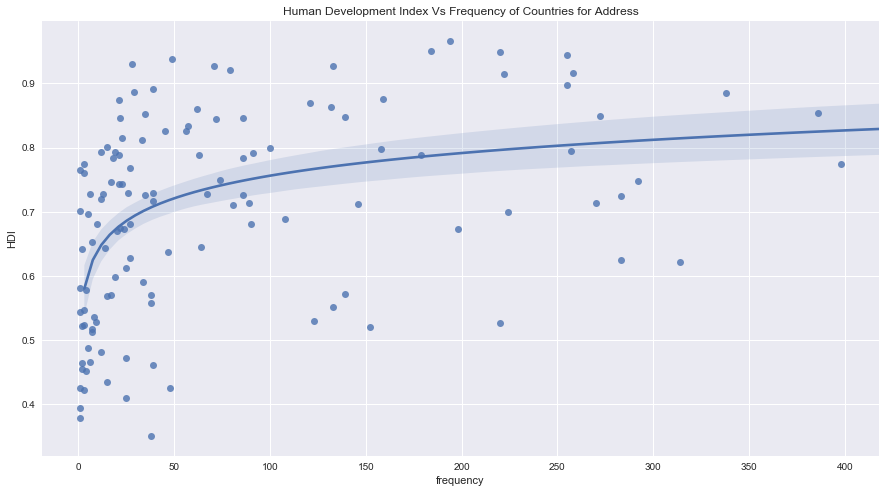

In [415]:
frequency=pd.DataFrame(panama_address["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

#select the country and the HDI index
dev_index=pd.DataFrame()
dev_index['HDI']=pd.to_numeric(dev['HDI'])
dev_index['Country']=dev['Country']
#merge HDI with frequency 
freq_hdi = pd.merge(frequency,dev_index,how='inner')
#only countries existing more than 100 times
freq_hdi =freq_hdi[freq_hdi['frequency'].apply(lambda x: x<400)]

freq_hdi=freq_hdi.dropna()
#plot the HDI index vs frquency 
#freq_hdi[['HDI','frequency']].plot(kind='scatter',logy=True, x='HDI', y='frequency', grid=True,figsize=(14,5))
title = "Human Development Index Vs Frequency of Countries for Address"
ax = sns.regplot(x="frequency", y="HDI", data=freq_hdi, n_boot=500, y_jitter=.03,logx=True).set_title(title)
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_hdi.HDI, freq_hdi.frequency)
#plt.plot(freq_hdi.HDI, intercept + slope*freq_hdi.HDI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

## 3.11 TAX Percentage
We wanted to see the reason behind going to the fiscal paradise. We tested the correlation with the last index which is the percentage of the taxes. As expected we find a correlation but a low correlation of  0.2490335967272295 with p value 0.018604013880805865 between the tax percentage and the frequency of officers countries. Officers in countries with high taxes tend more to evade taxes and put their money in fiscal paradises. 


Correlation Value 0.24903359672722972
P Value 0.01860401388080574


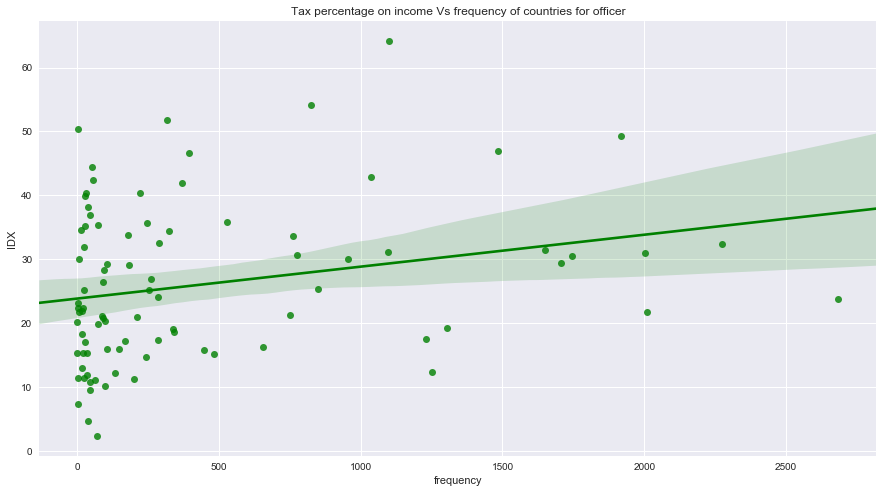

In [416]:
data_name="GC.TAX.YPKG.RV.ZS"
log_on=True
freq_limit=[0,3000]
idx_limit=[0,1000]
how='2016'
title = "Tax percentage on income Vs frequency of countries for officer"
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how, title)

# 4. Power Players

In this section we will explore the correlation between power players and the corruption index of a country. We want to see if there are more power players coming from an officially considered corrupted countries or there is no correlation at all.

##  4.1 Import list of power players in Panama and Paradise Papers

In [12]:
#Import and Clean Data 
power_players = pd.read_csv("./Data/panama_paradise_power_players.csv",encoding='latin-1')
power_players = power_players.drop(columns=["Unnamed: 0"])
power_players = pd.merge(power_players, corruption_index,how='inner')
power_players = power_players[["CPI","Politicians","Country"]]

In [13]:
power_players.head(10)

,CPI,Politicians,Country
0,36,Mauricio Macri,Argentina
1,36,Daniel MuÃ­Â±oz,Argentina
2,36,NÃ­Â©stor Grindetti,Argentina
3,57,Bidzina Ivanishvili,Georgia
4,78,Sigmundur DavÃ­_Ã­Ã Gunnlaugsson,Iceland
5,78,Bjarni Benediktsson,Iceland
6,78,Ã­Ã±lÃ­_f Nordal,Iceland
7,17,Ayad Allawi,Iraq
8,17,Mudhar Ghassan Shawkat,Iraq
9,48,Ali Abu al-Ragheb,Jordan


### 4.1.1 Distribution of Power Player Countries w.r.t corruption index

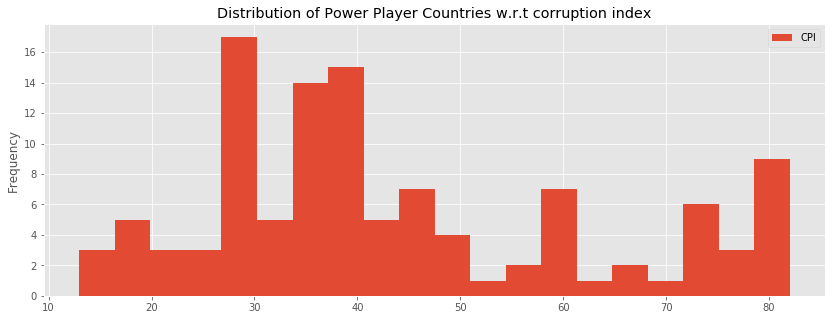

In [15]:
#only countries existing more than 100 times
freq_corruption = power_players[power_players['CPI'].apply(lambda x: x>1)]
#plot the corruption index vs frquency 
freq_corruption[['CPI','Country']].plot(kind='hist',bins=20, grid=True,figsize=(14,5), title="Distribution of Power Player Countries w.r.t corruption index")

### Interpretation

From the plot we can see that there are power players coming from almost all bins with a corruption index ranging from 0 to 100. Although we can notice that most of of the power players come from CPI indexes ranging from 25-50.  


# 5. Creation of The Graph

First we create the full graph. The edges are directed connections, as they give out information about who is shareholder of, intermediate of, director of, etc. Nodes can be an addresses, entities, intermediates or officers. Usually entities are connected to an address, and then officers are usually people, foundadations, companies, etc.

In [327]:
# Creates A Graph For a Given Dataset
def createG(edges, **kwargs):
    #Create an Empty Graph
    G = nx.DiGraph()
    
    #Loop through the data set and create nodes
    for k, v in kwargs.items():
        for n, row in v.iterrows():
            G.add_node(row.node_id, node_type = k, details = row.to_dict())
    
    #set up edges between nodes
    for n,row in edges.iterrows():
        G.add_edge(row['START_ID'], row['END_ID'], rel_type=row.TYPE, details=row.to_dict())
        
    return G

In [328]:
#Create Panama Papers Graph
panama_graph = createG(panama_edges, **{"entities" : panama_entity, "address" : panama_address,
                                       "intermediates" : panama_intermediary, "officers" : panama_officer})

In [329]:
#Create Paradise Papers Graph
paradise_graph = createG(paradise_edges, **{"entity" : paradise_entity, "address" : paradise_address,
                                       "intermediary" : paradise_intermediary, "officer" : paradise_officer,
                                           "other" : paradise_other})

In [330]:
nx.write_adjlist(panama_graph, "pp_graph1.adjlist")
nx.write_adjlist(paradise_graph, "pp_graph2.adjlist")

### 5.1 Paradise and Panama Papers Graph Analysis

In this subsection, we explore the importance of each node. Thus we create a dataframe with node_id, names of the node, type of the node(officer, intermediary, address, etc), degree and page rank. With this data frame we can have a clearer view on which are the most important nodes in the graph and what is so special about them. 

In [331]:
#Create a DF that contains node_id, degree, page_rank and type of node, name
def create_importance_df(graph):
    
    #Nodes in panama & paradise papers
    nodes = graph.nodes()
    degree = graph.degree()
    names = []
    typE = []
    degrees = []
    for i, node in enumerate(nodes):
        names.append(graph.node[node]["details"]["name"])
        typE.append(graph.node[node]["node_type"])
        degrees.append(degree[node])
    
    return pd.DataFrame(data = {"node_id" : nodes, "name" : names, "type" : typE, "degree" : degrees})

In [332]:
panama_df_importance = create_importance_df(panama_graph)
paradise_df_importance = create_importance_df(paradise_graph)

In [333]:
#Add a Page Rank Column to a Data Frames
def add_pr_column(df, pr):
    df["page_rank"] = pr[0].values
    return df

In [334]:
#Page Rank of Panama and Paradise Papers
panama_pr = nx.pagerank(panama_graph)
paradise_pr = nx.pagerank(paradise_graph)

In [335]:
panama_pr = pd.DataFrame.from_dict(panama_pr, orient='index')
paradise_pr = pd.DataFrame.from_dict(paradise_pr, orient='index')

In [336]:
#Add The Page Rank Column to Both Data Frames
panama_df_importance = add_pr_column(panama_df_importance, panama_pr)
paradise_df_importance = add_pr_column(paradise_df_importance, paradise_pr)

In [337]:
#Top 10 Nodes by Page Rank in Panama Papers
panama_df_importance.sort_values(by=["page_rank"],  ascending = False).head(10)

,node_id,name,type,degree,page_rank
199784,10200346,ACCELONIC LTD.,entities,1007,0.000766
238756,14025646,NaN,address,1007,0.000711
105135,10103570,VELA GAS INVESTMENTS LTD.,entities,493,0.000602
239120,14026010,NaN,address,813,0.000569
239178,14026068,NaN,address,686,0.000467
238819,14025709,NaN,address,667,0.000459
216595,14001929,NaN,address,495,0.000377
134311,10133161,Dale Capital Group Limited,entities,448,0.000336
215056,14007657,NaN,address,438,0.000328
277240,14064131,NaN,address,414,0.000297


In [338]:
#Top 10 Nodes by Page Rank in Paradise Papers
paradise_df_importance.sort_values(by=["page_rank"],  ascending = False).head(10)

,node_id,name,type,degree,page_rank
297364,81027146,Clifton House; 75 Fort Street; Grand Cayman KY...,address,9268,0.007300
297329,81027090,Canon's Court; 22 Victoria Street; Hamilton; H...,address,8558,0.004592
298590,81029389,Argyle House; 41a Cedar Avenue; Hamilton HM 12...,address,6120,0.003029
398665,58007938,"171 OLD BAKERY STREET, VALLETTA, MALTA",address,2505,0.002454
351397,88002083,BUITENLAND,address,2339,0.002251
367698,120001922,"CHANCERY HOUSE, HIGH STREET, HIGH STREET, BRID...",address,1772,0.001616
297327,81027087,Jayla Place; Wickhams Cay 1; Road Town; Tortol...,address,2101,0.001397
400065,58009618,"198, OLD BAKERY STREET, VALLETTANA00, MALTA",address,1277,0.001251
356201,88006887,"L.G. SMITH BLVD. 160, ORANJESTAD WEST",address,975,0.000950
332796,81073055,13-14 Esplanade; JE1 1BD St Helier; Jersey,address,1143,0.000902


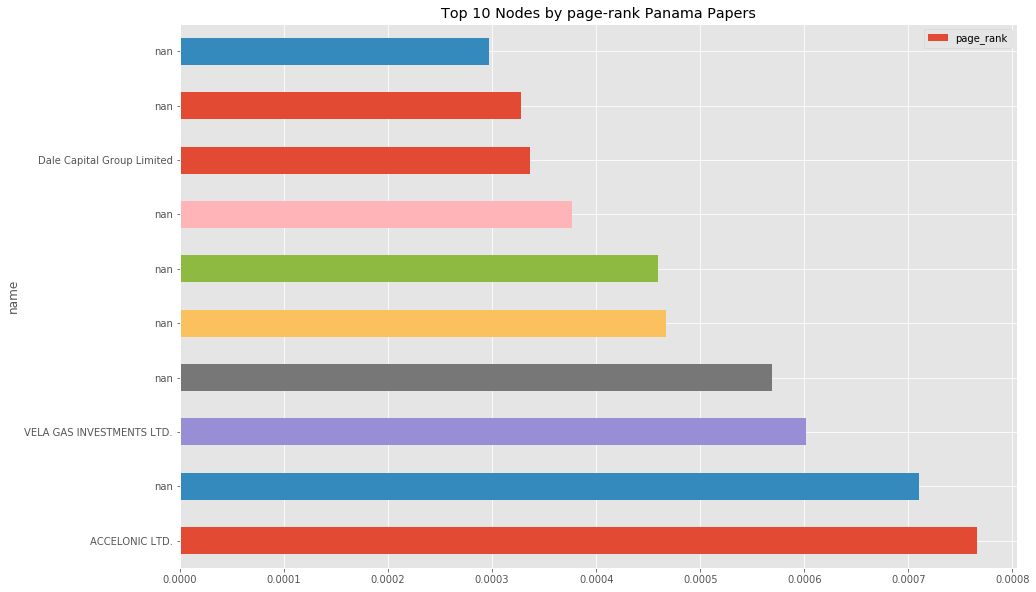

In [363]:
#Top 10 by Node Degree in Panama Papers

panama_df_importance.sort_values(by=["page_rank"],  ascending = False).head(10).plot.barh(x = "name", y = "page_rank", title = "Top 10 Nodes by page-rank Panama Papers", figsize = (15, 10))


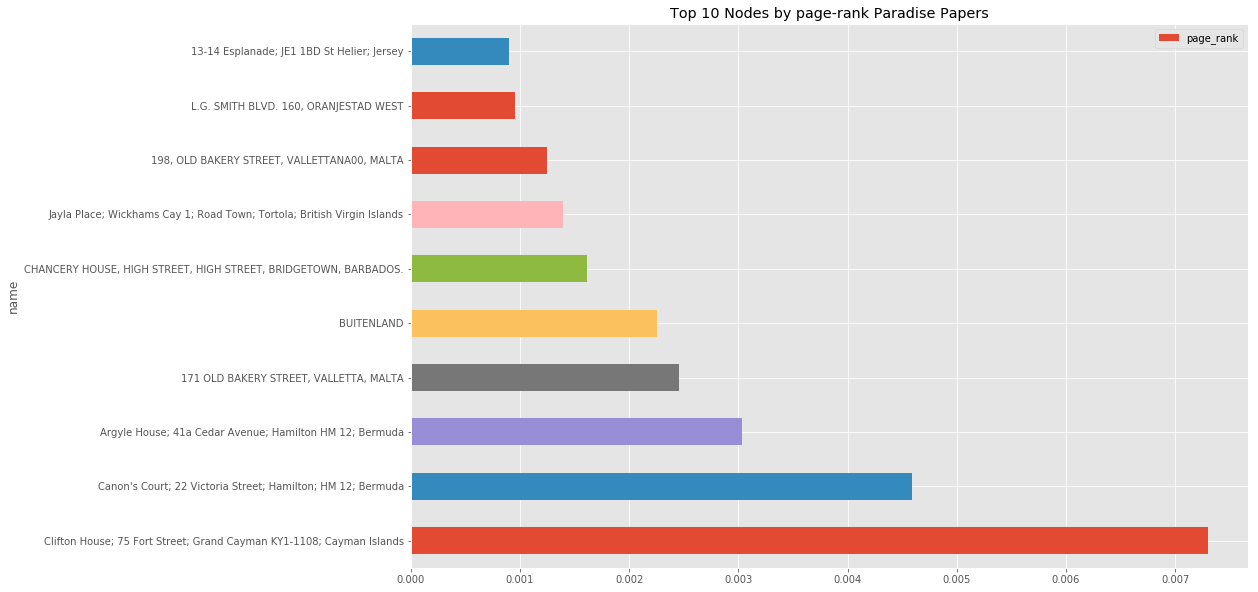

In [364]:
#Top 10 by Node Degree in Paradise Papers
paradise_df_importance.sort_values(by=["page_rank"], ascending = False).head(10).plot.barh(x = "name", y = "page_rank", title = "Top 10 Nodes by page-rank Paradise Papers", figsize = (15, 10))


#### Analysis of Pagerank 
We can notice that nodes with highest page rank in both datasets are mostly addresses. From a business point of view we could conclude that only certain people or companies offer opening an offshore company, therefore some addreses have an abudance of entities connected to them, thus making them part of a huge network. 

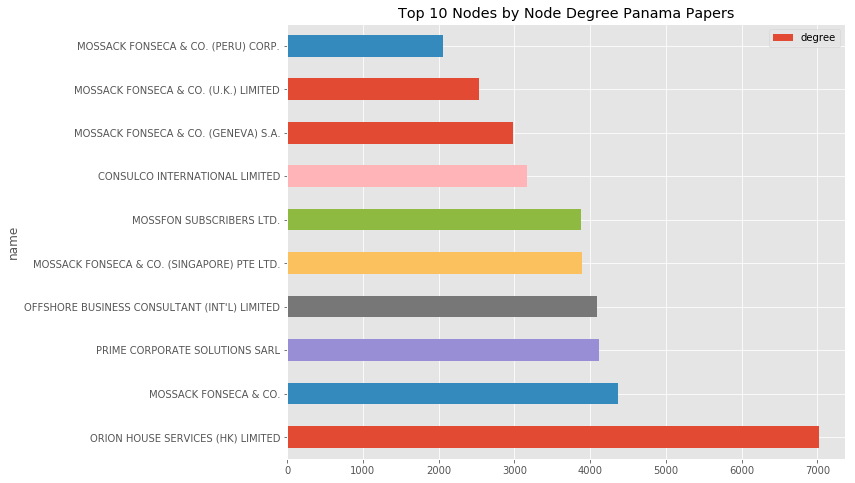

In [370]:
#Top 10 by Node Degree in Panama and Paradise Papers
panama_df_importance.sort_values(by=["degree"],  ascending = False).head(10).plot.barh(x = "name", y = "degree", title = "Top 10 Nodes by Node Degree Panama Papers", figsize = (10, 8))



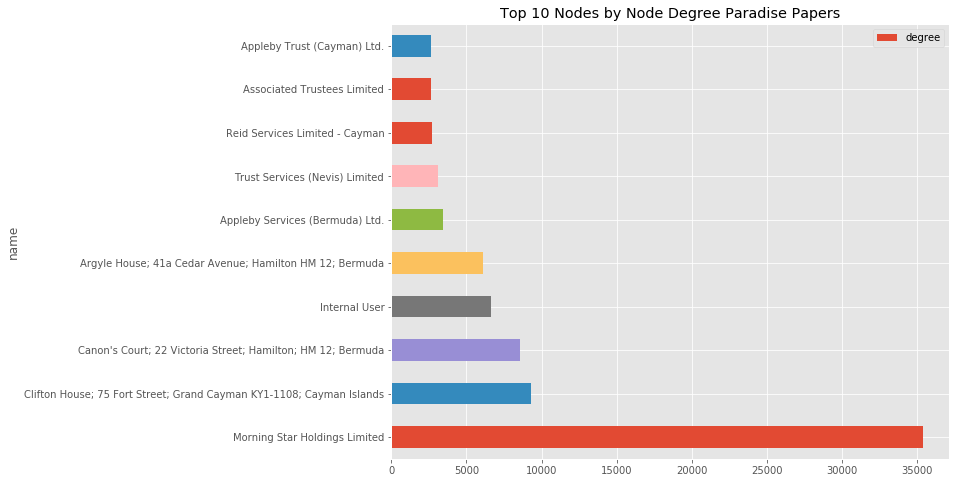

In [369]:
paradise_df_importance.sort_values(by=["degree"], ascending = False).head(10).plot.barh(x = "name", y = "degree", title = "Top 10 Nodes by Node Degree Paradise Papers", figsize = (10, 8))


In [340]:
panama_df_importance.sort_values(by=["degree"],  ascending = False).head(10)

,node_id,name,type,degree,page_rank
308844,11001746,ORION HOUSE SERVICES (HK) LIMITED,intermediates,7016,0.000001
318950,11011863,MOSSACK FONSECA & CO.,intermediates,4364,0.000001
319127,11012037,PRIME CORPORATE SOLUTIONS SARL,intermediates,4117,0.000001
308810,11001708,OFFSHORE BUSINESS CONSULTANT (INT'L) LIMITED,intermediates,4094,0.000001
315119,11008027,MOSSACK FONSECA & CO. (SINGAPORE) PTE LTD.,intermediates,3888,0.000001
480771,12160432,MOSSFON SUBSCRIBERS LTD.,officers,3883,0.000001
316439,11009351,CONSULCO INTERNATIONAL LIMITED,intermediates,3168,0.000001
314457,11007372,MOSSACK FONSECA & CO. (GENEVA) S.A.,intermediates,2986,0.000001
318631,11011539,MOSSACK FONSECA & CO. (U.K.) LIMITED,intermediates,2538,0.000001
316233,11009139,MOSSACK FONSECA & CO. (PERU) CORP.,intermediates,2055,0.000001


In [341]:
paradise_df_importance.sort_values(by=["degree"], ascending = False).head(10)

,node_id,name,type,degree,page_rank
514996,230000018,Morning Star Holdings Limited,intermediary,35359,5.269522e-07
297364,81027146,Clifton House; 75 Fort Street; Grand Cayman KY...,address,9268,7.299897e-03
297329,81027090,Canon's Court; 22 Victoria Street; Hamilton; H...,address,8558,4.592053e-03
513931,32000236,Internal User,intermediary,6607,5.269522e-07
298590,81029389,Argyle House; 41a Cedar Avenue; Hamilton HM 12...,address,6120,3.029270e-03
513438,80000191,Appleby Services (Bermuda) Ltd.,intermediary,3449,5.269522e-07
514938,230000057,Trust Services (Nevis) Limited,intermediary,3114,5.269522e-07
515179,80011987,Reid Services Limited - Cayman,officer,2704,5.269522e-07
514931,230000005,Associated Trustees Limited,intermediary,2636,5.269522e-07
513444,80011301,Appleby Trust (Cayman) Ltd.,intermediary,2632,5.269522e-07


#### Analysis of Node Degree
We can see that the nodes with higest degrees are mostly intermediaries. This actually makes sense, since intermediaries actually serve for helping clients. The role of intermediaries were typically  to deal with trust companies like Mossack Fonseca in panama papers and to set up offshore companies for clients. Most of the intermediaries are based outside onshore jurisdictions and sometimes, therefore they are subject to different laws, thus making it very difficult to influence them, especially the trust companies. 

### Explore Network of King Salman bin Abdulaziz bin Abdulrahman Al Saud - King of Saudi Arabia
In this subsection we will explore the connection of power player that was found in the panama papers. We will expore the network of King of Saudi Arabia - Salman bin Abdulaziz bin Abdulrahman Al Saud. 

In [342]:
#Explore Network for Tax Evasion Comapnies that are surronded around King Salman bin Abdulaziz bin Abdulrahman Al Saud
kingSaudiArabia = "King Salman bin Abdulaziz bin Abdulrahman Al Saud"

#Check if he actually exists in the data.
panama_officer[panama_officer["name"] == kingSaudiArabia]

,node_id,name,country_codes,countries,sourceID,valid_until,note
238383,15004501,King Salman bin Abdulaziz bin Abdulrahman Al Saud,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,Record manually added from leaked documents


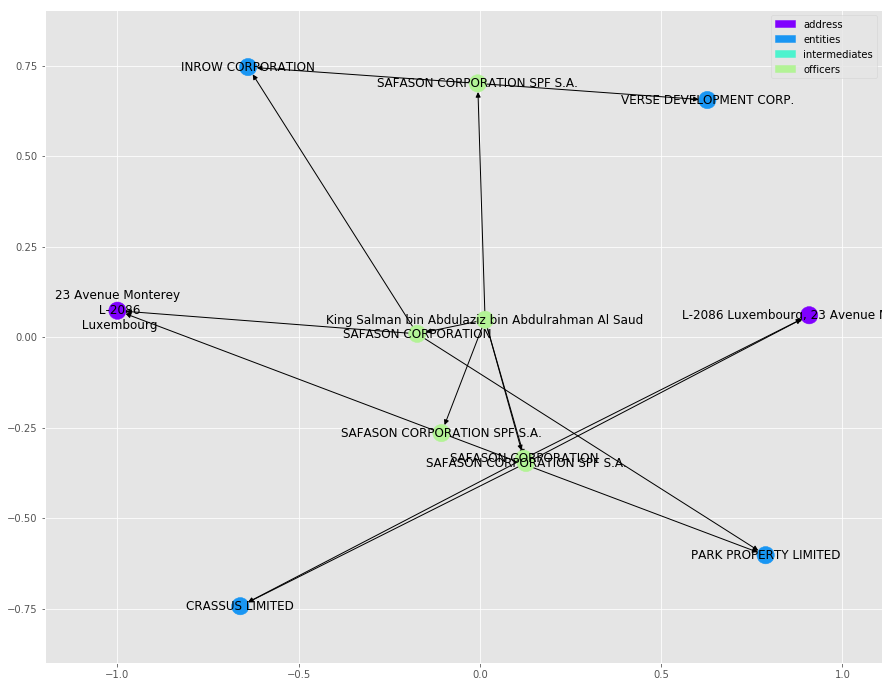

In [343]:
#Create a subgraph(connected component, which will shows with what nodes does the king interact) by BFS
kingGraph = panama_graph.subgraph(nx.shortest_path(panama_graph, 15004501))
plot_graph(kingGraph, figsize=(15,12), label_edges=False)

As we can see the King is connected to a couple of companies all having almost the same name(probably are the same company) which are being officers, the company address is in Luxembourg. these companies are then connected to actual offshore entities. We can see that this SAFASON CORPORATION SPF is connected to various other entties VERSE DEVELOPMENT CORP, CRASSUS LIMITED, PARK PROPERTY LIMITED, CRASSUS LIMITED. 

Another thing that we can notice is how unclean the data is. There are multiple nodes with almost the same address, which in reallity is probably the same address, same thing goes for the officers. However, this is understandable as people that constructed this data were dealing with a lot of information and material. 

In [344]:
#Expore VERSE DEVELOPENT CORP, 
listOfEntities = ["VERSE DEVELOPMENT CORP.", "PARK PROPERTY LIMITED", "INROW CORPORATION", "CRASSUS LIMITED"] 
display(panama_entity[panama_entity["name"].isin(listOfEntities)])

,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
12461,10012580,VERSE DEVELOPMENT CORP.,PMA,Panama,JOR,Jordan,18-NOV-1999,NaN,NaN,NaN,83,Active,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
29260,10029473,INROW CORPORATION,PMA,Panama,JOR,Jordan,07-NOV-2002,NaN,NaN,NaN,59,Active,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
99766,10113689,CRASSUS LIMITED,BVI,British Virgin Islands,JOR,Jordan,13-AUG-2004,NaN,NaN,NaN,610410,Active,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
121865,10120252,PARK PROPERTY LIMITED,BVI,British Virgin Islands,JOR,Jordan,22-AUG-2005,NaN,NaN,NaN,673104,Active,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN


We can see that Verse Development Corp. was incorporated in 1991 in Panama, under the country Jordan, in fact all of the companies are under country Jordan. All of the entities are a still activate, and they are residing in 2 jurisdictions Panama and British Virgin Islands.

# 6. References

[1] https://github.com/Roussaky/ada-EPFL/blob/master/project/project_notebook.ipynb

[2] https://github.com/REDeLapp/Panama-Papers-Network-Analysis

[3] https://github.com/amaboura/panama-papers-dataset-2016

[4] https://github.com/ijmbarr/panama-paper-network/blob/master/panama_network.ipynb

[5] http://www.europarl.europa.eu/RegData/etudes/STUD/2017/602030/IPOL_STU(2017)602030_EN.pdf

[6] https://www.swissinfo.ch/eng/business/suspect-activity_panama-papers-put-swiss-lawyers-in-tight-spot/42074556

[7] https://www.theguardian.com/news/2016/apr/03/what-you-need-to-know-about-the-panama-papers